<a href="https://colab.research.google.com/github/nerea-observatory/internalwaves/blob/main/notebook_iw_param.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Internal wave parameterization from CTD and LADCP data
##### Notebook by Florian Kokoszka
##### **florian.kokoszka @ na.ismar.cnr.it**
##### **florian.kokoszka @ szn.it**

##### November 2023

# Installs & declarations

In [34]:
pip install gsw

In [35]:
def center_array_indices(x_in, N):
    l = len(x_in)
    M = np.round((N-1)/2)+1
    x_out = np.array([np.nan]*l)
    x_out[int(N-M):int(l-M)] = x_in[N:l]
    return x_out

def interpholes(x_in, y_in, x_out):
    ff = np.where((np.isfinite(y_in)))[0]
    y_out = np.interp(x_out, x_in[ff], y_in[ff])
    return y_out

def iserror(func, *args, **kw):
    try:
        func(*args, **kw)
        return False
    except Exception:
        return True

In [36]:
import numpy as np  #The basic python scientific package
import matplotlib.pyplot as plt #Simple visualisation package
import seaborn as sns #Datascience visualisation package
import pandas as pd #Datascience package for handling data
from datetime import datetime
from time import time

import math
import gsw
from pathlib import Path

from scipy import stats
from scipy.optimize import curve_fit

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display, Math, Latex

from scipy import signal

from scipy.stats import t

import random
from random import randrange
from pandas import Series
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#import mat73
from matplotlib import gridspec
from scipy.signal import welch, tukey

# Load data
### from .csv files (Github)
##### Notebook repository (to be uploaded)  https://github.com/nerea-observatory/internalwaves

##### Data (csv extractions from the .mat) https://github.com/nerea-observatory/internalwaves/tree/main/data

In [37]:
url_ITcoast = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/coast/ITcoast.csv'

url_latGEBCO = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/gebco/latGEBCO.csv'
url_lonGEBCO = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/gebco/lonGEBCO.csv'
url_zzGEBCO = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/gebco/zzGEBCO.csv'

url_P = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/P.csv'
url_D = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/D.csv'
url_T = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/T.csv'
url_S = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/S.csv'
url_CT = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/CT.csv'
url_SA = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/SA.csv'
url_SIG0 = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/SIG0.csv'
url_N2 = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/N2.csv'
url_U = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/U.csv'
url_V = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/V.csv'
url_META = 'https://raw.githubusercontent.com/nerea-observatory/internalwaves/main/data/iono/km3/ctd_ladcp/META.csv'

In [38]:
import pandas as pd

ITcoast = pd.read_csv(url_ITcoast)

latGEBCO = pd.read_csv(url_latGEBCO)
lonGEBCO = pd.read_csv(url_lonGEBCO)
zzGEBCO  = pd.read_csv(url_zzGEBCO)

META = pd.read_csv(url_META,index_col = [0])

P = np.array(pd.read_csv(url_P,index_col = [0]))
D = np.array(pd.read_csv(url_D,index_col = [0]))
T = np.array(pd.read_csv(url_T,index_col = [0]))
S = np.array(pd.read_csv(url_S,index_col = [0]))
CT = np.array(pd.read_csv(url_CT,index_col = [0]))
SA = np.array(pd.read_csv(url_SA,index_col = [0]))
SIG0 = np.array(pd.read_csv(url_SIG0,index_col = [0]))
N2 = np.array(pd.read_csv(url_N2,index_col = [0]))

U = np.array(pd.read_csv(url_U,index_col = [0]))
V = np.array(pd.read_csv(url_V,index_col = [0]))

sta = np.array(META['sta'])
btd = np.array(META['btd'])
lon_ctd = np.array(META['lon_ctd'])
lat_ctd = np.array(META['lat_ctd'])
dt = np.array(META['dt'])
ts = np.array(META['ts'])
lon = lon_ctd*1
lat = lat_ctd*1

NSMOOTHING = 0


# Functions & decla :
##### GM, Spectra in situ, integration range

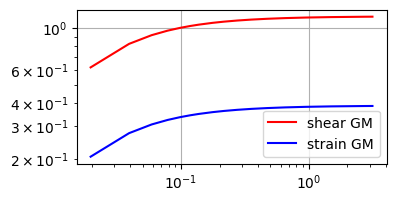

In [39]:
# PARAM GM
def GM_model(KZ,dk,N2m):
    latref =  30
    e0 = 7e-10
    Elevel = 6.3e-5
    bGM = 1300
    Jstar = 3
    N0 = 5.2e-3
    K0 = 5e-6
    kzstar = np.pi*Jstar* np.sqrt(N2m)  / (bGM*N0)
    cstGM = (np.pi*Elevel*Jstar*bGM)/2
    terme = cstGM*( KZ**2 )/ (KZ+kzstar)**2
    KZ_GM = KZ
    spectrum_strain_GM = terme
    spectrum_shear_GM = 3.*terme
    return KZ_GM, spectrum_shear_GM, spectrum_strain_GM


nperseg = 320
noverlap = nperseg/1
#
resolution = 1
LFFT = nperseg
NFFT = nperseg
dk = 2*np.pi / LFFT
LZ = np.arange(1,LFFT+1,1)*resolution
LZinv = resolution*resolution*NFFT/LZ
LZinv = LZinv[0:int(NFFT/2)]
LZ = LZinv
KZ = (1/LZ)*2*np.pi  # rad m-1 : ok
NSQ = 5e-6
N0 = 5.2e-3
N02 = N0**2
KZ_GM, spectrum_shear_GM, spectrum_strain_GM = GM_model(KZ,dk,N02)


fig , axs =  plt.subplots(1, 1, figsize=(4,2))
ax = axs
ax.plot(KZ_GM, spectrum_shear_GM, 'r-',label='shear GM')
ax.plot(KZ_GM, spectrum_strain_GM, 'b-',label='strain GM')
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()
ax.legend()

In [40]:
from scipy import signal
from scipy.signal import welch, tukey

def calculate_strain(N2_in,N2M,i1,i2,iprofile):
    N2p = N2_in[i1:i2,iprofile]
    N2m = np.nanmean(N2_in[i1:i2,iprofile])
    N2t = N2M[i1:i2]

    ximean  = (N2p - N2m)/N2m

    polyf = np.polyfit(np.arange(i1,i2,1), N2p, 4)
    polyd = np.poly1d(polyf)
    N2fit = polyd(np.arange(i1,i2,1))
    xifit  = (N2p - N2fit)/N2m

    xitime  = (N2p - N2t)/N2m

    return ximean, xifit, xitime, N2m, N2p, N2t




def spectrum_iw_strain(nperseg,xi, N2m,percent_windowing,varloss):
    noverlap = nperseg/2
    scaling = 'spectrum'
    #
    resolution = 1
    LFFT = nperseg
    NFFT = nperseg
    dk = 2*np.pi / LFFT
    LZ = np.arange(1,LFFT+1,1)*resolution
    LZinv = resolution*resolution*NFFT/LZ
    LZinv = LZinv[0:int(NFFT/2)]
    LZ = LZinv
    KZ = (1/LZ)*2*np.pi

    KZ_GM, spectrum_shear_GM, spectrum_strain_GM = GM_model(KZ,dk,N2m) # N2m in rad s-1

    #
    f, psd_strain = welch(xi, dk,
                 window=signal.windows.tukey(nperseg,percent_windowing),
                   nperseg=nperseg,
                   noverlap=noverlap,
                   detrend='linear',
                   return_onesided=True,scaling=scaling)
    f = f[1:]
    psd_strain=varloss*psd_strain[1:]

    return psd_strain, spectrum_strain_GM





def spectrum_iw_shear(nperseg, u,v,N2m,percent_windowing,varloss):
    noverlap = nperseg/2
    scaling = 'spectrum'
    #
    resolution = 1
    LFFT = nperseg
    NFFT = nperseg
    dk = 2*np.pi / LFFT
    LZ = np.arange(1,LFFT+1,1)*resolution
    LZinv = resolution*resolution*NFFT/LZ
    LZinv = LZinv[0:int(NFFT/2)]
    LZ = LZinv
    KZ = (1/LZ)*2*np.pi

    KZ_GM, spectrum_shear_GM, spectrum_strain_GM = GM_model(KZ,dk,N2m) # N2m in rad s-1

    f, psd_u = welch(u, dk,
                        window=signal.windows.tukey(nperseg,percent_windowing),
                       nperseg=nperseg,
                       noverlap=noverlap,
                       detrend='linear',
                       nfft=None,
                       return_onesided=True,scaling=scaling)
    psd_u=varloss*psd_u[1:]
    #
    f, psd_v = welch(v, dk,
                     window=signal.windows.tukey(nperseg,percent_windowing),
                   nperseg=nperseg,
                   noverlap=noverlap,
                   detrend='linear',
                   nfft=None,
                   return_onesided=True,scaling=scaling)
    psd_v=varloss*psd_v[1:]
    #
    psd_uv = (psd_u)+(psd_v)
    psd_shear = (psd_uv)*(KZ**2)
    return psd_shear, spectrum_shear_GM



In [41]:
LZround = np.round(LZ).astype(int)
print('Wavelengthes available')
print(-np.sort(-np.unique(LZround)))

print('')
l320 = np.where(LZround==320)[0]
l160 = np.where(LZround==160)[0]
l107= np.where(LZround==107)[0]
l80= np.where(LZround==80)[0]
l64= np.where(LZround==64)[0]
l53= np.where(LZround==53)[0]
l46= np.where(LZround==46)[0]
l40= np.where(LZround==40)[0]
l36= np.where(LZround==36)[0]
l32= np.where(LZround==32)[0]
l29= np.where(LZround==29)[0]
l27= np.where(LZround==27)[0]
l25= np.where(LZround==25)[0]
l23= np.where(LZround==23)[0]
l21= np.where(LZround==21)[0]
l20= np.where(LZround==20)[0]
l10= np.where(LZround==10)[0][0]

lsta_strain = int(l160)
lend_strain = int(l20)
lsat_strain = lend_strain

lsta_shear = int(l320)
lend_shear = int(l53)
lsat_shear = lend_shear

print('Bounds integration shear (m):  start',LZround[lsta_shear],'end',LZround[lend_shear],'saturation',LZround[lsat_shear])
print('Bounds integration strain (m): start',LZround[lsta_strain],'end',LZround[lend_strain],'saturation',LZround[lsat_strain])

Wavelengthes available
[320 160 107  80  64  53  46  40  36  32  29  27  25  23  21  20  19  18
  17  16  15  14  13  12  11  10   9   8   7   6   5   4   3   2]

Bounds integration shear (m):  start 320 end 53 saturation 53
Bounds integration strain (m): start 160 end 20 saturation 20


In [42]:
N02

2.704e-05

In [43]:
# check the GM values for various bounds

N02 = 2e-4
N02 = 2e-6
N02 = 2e-8

KZ_GM, spectrum_shear_GM, spectrum_strain_GM = GM_model(KZ,dk,N02)

print(np.trapz(spectrum_shear_GM[int(l320):int(l53)]*dk))
print(np.trapz(spectrum_strain_GM[int(l160):int(l20)]*dk))

0.09017392065877086
0.09820541123415945


In [44]:
L = 320

N2_in = N2*1

N2M = np.array([np.nan]*N2_in.shape[0])
for p in range(0,N2_in.shape[0]):
    N2M[p] = np.nanmean(N2_in[p,:])


for iprofile in range(0,N2_in.shape[1]):
    print(iprofile)
    XI = []
    if int(np.nanmax(D[:,iprofile]))>L:
        TRANSMAX = int(int(np.nanmax(D[:,iprofile]))-(L+L/2))
        for trans in range(0,TRANSMAX,1):
            #2400
            i2 = int(np.nanmax(D[:,iprofile])-(L/2 +1)-trans)  # à - (L/2  +1) du dernier point (ex: -161)
            i1 = i2-L

            ximean, xifit, xitime, N2m, N2p, N2t = calculate_strain(N2_in,N2M,i1,i2,iprofile)

            XI.append([iprofile,np.nanmean([i1,i2]),i1,i2,ximean,np.nanvar(ximean),xifit,np.nanvar(xifit),xitime,np.nanvar(xitime),])
        exec('XI'+str(iprofile)+'=  np.array(XI)' )

<ipython-input-44-10bb580371ab>:7: RuntimeWarning: Mean of empty slice
  N2M[p] = np.nanmean(N2_in[p,:])


0
1
2
3


<string>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


In [45]:
XI6.shape

(2959, 10)

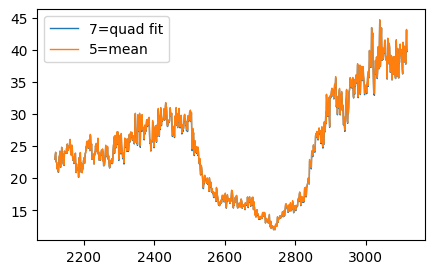

In [46]:
fig , axs =  plt.subplots(1, 1, figsize=(5,3))
ax = axs
zref=1000
ax.plot(XI6[:zref,1],XI6[:zref,7],label='7=quad fit',lw=1)
ax.plot(XI6[:zref,1],XI6[:zref,5],label='5=mean',lw=1)
ax.legend()

figure_name = 'check_strains.pdf'
plt.savefig(figure_name)
#files.download(figure_name)

# Spectra calculations
##### rolling windows of 320m in a 640m larger window.

##### To avoid the choice of cutting the water-column into segments at fixed depths and avoid overlapping by x percents, we simply translate the FFT window 1m by 1m, from bottom to surface, into a layer of thickness H that we consider encapsulating the deep signal.

##### We calculate 320 x spectra (FFT on 320m segments, translated 320 times of 1m from the deepest data point toward the surface). Values are interpreted centered on each segment, and we will use each of them to produce boxplots (i.e. incertitudes).

##### **NOTE** : case NK28 (shallow depth) is not coded


In [47]:
# inputs
N2_in = N2*1
U_in = U*1
V_in = V*1
D_in = D*1
N2M = np.array([np.nan]*N2_in.shape[0])
for p in range(0,N2_in.shape[0]):
    N2M[p] = np.nanmean(N2_in[p,:])

# declarations
L = 320
percent_windowing_strain = .10
varloss_strain = 1.07
percent_windowing_shear = .10
varloss_shear = 1.25

# 1 saturation not considered
# 2 saturation is considered
VAR1 = []
VAR2 = []
PSD_SHEAR = []
PSD_STRAIN = []

RW1 = []
RW2 = []

FRW1 = []
FRW2 = []

FHI1 = []
FHI2 = []

LFN = []
RN2 = []
RF = []
BV2 = []

STA = []
META = []

for iprofile in range(0,N2_in.shape[1]):
    print(iprofile)

    if int(np.nanmax(D[:,iprofile]))>2*L:
        #TRANSMAX = int(int(np.nanmax(D_in[:,iprofile]))-(L+L/2))
        TRANSMAX = 320
        for trans in range(0,TRANSMAX,1):
            i2 = int(np.nanmax(D[:,iprofile])-(0/2 +1)-trans)  # à - (L/2  +1) du dernier point (ex: -161)
            i1 = i2-L

            # calculate various strain estimates
            ximean, xifit, xitime, N2m, N2p, N2t = calculate_strain(N2_in,N2M,i1,i2,iprofile)
            xi = ximean
            #xi = xifit

            fi = np.where(np.isfinite(xi)==1)[0]
            if len(fi)==L:

                # PSD(strain) and spectral integrations
                #
                psd_strain, spectrum_strain_GM = spectrum_iw_strain(320,xi, N2m,percent_windowing_strain,varloss_strain)
                va_strain = np.trapz(psd_strain[lsta_strain:lsat_strain+1]*dk)
                va_strain_GM = np.trapz(spectrum_strain_GM[lsta_strain:lsat_strain+1]*dk)
                # ----------------
                if va_strain > 0.1:
                        va_strain_sat = 0.1
                        va_strain_sat_GM = np.trapz(spectrum_strain_GM[lsta_strain:int(l20)+1]*dk) # l20 <------------
                else:   va_strain_sat = va_strain*1 ; va_strain_sat_GM = va_strain_GM*1
                # ----------------
                r_strain = va_strain / va_strain_GM
                r_strain_2 = va_strain**2 / va_strain_GM**2
                #
                r_strain_sat = va_strain_sat / va_strain_sat_GM
                r_strain_sat_2 = va_strain_sat**2 / va_strain_sat_GM**2

                # PSD(shear) and spectral integrations
                #
                u = U_in[i1:i2,iprofile]
                v = V_in[i1:i2,iprofile]
                psd_shear, spectrum_shear_GM = spectrum_iw_shear(320,u,v, (N2m),percent_windowing_shear,varloss_shear)
                consider_saturation = True
                va_shear = np.trapz(psd_shear[lsta_shear:lsat_shear+1]*dk) ## use the fit or raw
                va_shear = va_shear / N2m
                va_shear_GM = np.trapz(spectrum_shear_GM[lsta_shear:lsat_shear+1]*dk)
                # ----------------
                if va_shear > 0.1:
                        va_shear_sat = 0.1
                        va_shear_sat_GM = np.trapz(spectrum_shear_GM[lsta_shear:int(l53)+1]*dk)  # l53 <------------
                else:   va_shear_sat = va_shear*1 ; va_shear_sat_GM = va_shear_GM*1
                # ----------------
                r_shear = va_shear / va_shear_GM
                r_shear_2 = va_shear**2 / va_shear_GM**2
                #
                r_shear_sat = va_shear_sat / va_shear_sat_GM
                r_shear_sat_2 = va_shear_sat**2 / va_shear_sat_GM**2

                # ----------------
                vals1 = [va_shear,va_shear_GM,r_shear,r_shear_2,va_strain,va_strain_GM,r_strain,r_strain_2]
                vals2 = [va_shear_sat,va_shear_sat_GM,r_shear_sat,r_shear_sat_2,va_strain_sat,va_strain_sat_GM,r_strain_sat,r_strain_sat_2]
                #
                VAR1.append(vals1)
                VAR2.append(vals2)
                #
                PSD_SHEAR.append(psd_shear/N2m)
                PSD_STRAIN.append(psd_strain)
                del vals1, vals2

                # ----------------
                rw = ( r_shear/r_strain )*3
                rw_sat = ( r_shear_sat/r_strain_sat )*3
                if rw < 1 : rw = 1.01
                if rw_sat < 1 : rw_sat = 1.01
                RW1.append(rw)
                RW2.append(rw_sat)




                # ----------------
                frw_strain = (1/(6*np.sqrt(2)))*(rw*(rw+1))/(np.sqrt(rw-1))
                frw_shear =  ( 3*(rw+1) ) / ( 2*np.sqrt(2)*rw*np.sqrt(rw-1))
                frw_strain_sat = (1/(6*np.sqrt(2)))*(rw_sat*(rw_sat+1))/(np.sqrt(rw_sat-1))
                frw_shear_sat =  ( 3*(rw_sat+1) ) / ( 2*np.sqrt(2)*rw_sat*np.sqrt(rw_sat-1))
                #
                rw_ref = 7
                frw_strain_rw7 = (1/(6*np.sqrt(2)))*(rw_ref*(rw_ref+1))/(np.sqrt(rw_ref-1))
                rw_ref = 3
                frw_strain_rw3 = (1/(6*np.sqrt(2)))*(rw_ref*(rw_ref+1))/(np.sqrt(rw_ref-1))
                #
                vals1 = [frw_shear,frw_strain,frw_strain_rw3,frw_strain_rw7]
                vals2 = [frw_shear_sat,frw_strain_sat,frw_strain_rw3,frw_strain_rw7]
                FRW1.append(vals1)
                FRW2.append(vals2)
                del vals1, vals2

                # ---------------- L and Hibiya
                lon_p =  lon[iprofile]
                lat_p =  lat[iprofile]
                f_coriolis = gsw.geostrophy.f(lat[iprofile])
                f30 = gsw.geostrophy.f(30)
                N0 = 5.2e-3
                if iserror(math.acosh,np.sqrt(N2m)/f_coriolis) == False:
                    lfN =  np.abs( ( f_coriolis*math.acosh( np.sqrt(N2m)/f_coriolis) ) / ( f30*math.acosh( N0/f30) ) )

                    # ---------------- F(Hibiya)
                    # log3(x) = log10(x)/log10(3)
                    LN = (1/(2*np.pi))* math.acosh( np.sqrt(N2m)/f_coriolis )
                    L0 = (1/(2*np.pi))*math.acosh( N0/f30)

                else: lfN = 1 ; LN = 1 ; L0 = 1 ; print('math.acosh error ! L(f,N) = 1') # the math package create bullshit errors ....
                #
                LFN.append(lfN)
                BV2.append(N2m)
                RN2.append(N2m/N0**2)
                RF.append(f_coriolis/f30)



                # ---------------- F(Hibiya)
                # log3(x) = log10(x)/log10(3)
                L0 ;
                LN ;
                L1 = 2 * (LN**2)
                L2 = np.log10(2* LN)/np.log10(3)

                h_GHP1 = ((1+1/rw)/(4/3)) * (LN/L0) * np.sqrt(2 / (rw -1))
                h_GHP2 = ((1+1/rw_sat)/(4/3)) * (LN/L0) * np.sqrt(2 / (rw_sat -1))

                if rw <= 9 : h_HI1 = ((1+1/rw)/(4/3)) * (L1 / L0) * (rw**(-L2))
                elif rw > 9: h_HI1 = ((1+1/rw)/(4/3)) * (1 /L0) * np.sqrt(2 / (rw -1))
                #
                if rw_sat <= 9 : h_HI2 = ((1+1/rw_sat)/(4/3)) * (L1 / L0) * (rw_sat**(-L2))
                elif rw_sat > 9: h_HI2 = ((1+1/rw_sat)/(4/3)) * (1 /L0) * np.sqrt(2 / (rw_sat -1))

                vals1 = [h_HI1,h_GHP1]
                vals2 = [h_HI2,h_GHP2]
                FHI1.append(vals1)
                FHI2.append(vals2)
                del vals1, vals2


                # ----------------
                vals = [iprofile,np.nanmean([i1,i2]),i1,i2,lon_p,lat_p,f_coriolis,f30,N2m]
                META.append(vals)
                STA.append(sta[iprofile])
                del vals

VAR1 = np.array(VAR1)
VAR2 = np.array(VAR2)

PSD_SHEAR = np.array(PSD_SHEAR)
PSD_STRAIN = np.array(PSD_STRAIN)

RW1 = np.array(RW1)
RW2 = np.array(RW2)

FRW1 = np.array(FRW1)
FRW2 = np.array(FRW2)

FHI1 = np.array(FHI1)
FHI2 = np.array(FHI2)

LFN = np.array(LFN)
RN2 = np.array(RN2)
RF = np.array(RF)
BV2 = np.array(BV2)

STA = np.array(STA)
META = np.array(META)



rw1 = np.array([np.nan]*len(sta))
rw2 = np.array([np.nan]*len(sta))
for i in range(0,len(sta)):
    fsta = np.where(META[:,0]==i)[0]
    if len(fsta)>0:
        rw1[i] = np.nanmean(RW1[fsta])
        rw2[i] = np.nanmean(RW2[fsta])


print('\nOK')


<ipython-input-47-e3ded427c696>:8: RuntimeWarning: Mean of empty slice
  N2M[p] = np.nanmean(N2_in[p,:])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
math.acosh error ! L(f,N) = 1
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37

OK


# Bathymetry calculations
##### GEBCO
##### **24 points = 10 km**
##### 80 points = 35 km

In [48]:
lon = np.array(lonGEBCO).flatten()
lat = np.array(latGEBCO).flatten()
ZZ = np.array(zzGEBCO)

lonG = lon*1
latG = lat*1
ZZG = ZZ*1

Nreduce = 10
ZZ = ZZ[np.arange(0,len(lat),Nreduce),:][:,np.arange(0,len(lon),Nreduce)]
lon = lon[np.arange(0,len(lon),Nreduce)]
lat = lat[np.arange(0,len(lat),Nreduce)]
XX, YY = np.meshgrid(lon + np.nanmean(np.diff(lon))/2,lat + np.nanmean(np.diff(lat))/2)

print(XX.shape,YY.shape,ZZ.shape)
print(lonG.shape, latG.shape)

(96, 168) (96, 168) (96, 168)
(1680,) (960,)


In [49]:
sta, lon_ctd, lat_ctd, btd

(array(['NK19', 'NK20', 'NK9', 'NK8', 'NK8b', 'NK6', 'NK5', 'NK4', 'KM4',
        'NK2', 'NK1', '11', '3', '12', '13', 'GR2', 'GR1', 'NK17', 'NK10',
        'NK11', 'NK12', 'NK13', 'NK14', 'NK15', 'NK18', 'KM3', 'NK21',
        'NK22', 'NK23', 'NK24', 'NK25', 'NK26', 'NK27', 'NK28', 'NK30',
        'NK31', 'NK32', 'NK34'], dtype=object),
 array([15.3666    , 15.41668   , 15.46557   , 15.51614494, 15.51658   ,
        15.65744   , 15.83308532, 16.00032   , 16.09992   , 16.29989   ,
        16.54988   , 16.94418   , 17.80325   , 19.09621   , 20.06232   ,
        21.48323   , 21.13321   , 18.43687   , 16.31675   , 16.14997   ,
        16.00034   , 15.83292   , 15.64255   , 15.53341   , 15.36667   ,
        15.83353   , 16.01183   , 15.94631   , 15.92024   , 15.87026   ,
        15.87667   , 15.85287   , 15.8379    , 15.83121   , 16.2461    ,
        16.34373   , 16.4861    , 16.87865   ]),
 array([36.31662   , 36.38348   , 36.43357   , 36.43370494, 36.4336    ,
        36.40165   , 36.374

In [50]:
FLON = []
FLAT = []
FZZG = []

LONG = []
LATG = []
for i in range(0,len(sta)):
  difflon = np.abs(lon_ctd[i]-lonG)
  difflat = np.abs(lat_ctd[i]-latG)

  flon = np.where(difflon == np.nanmin(difflon))[0]
  flat = np.where(difflat == np.nanmin(difflat))[0]

  FLON.append(flon)
  FLAT.append(flat)
  FZZG.append(ZZG[flat,flon])

  LONG.append(lonG[flon])
  LATG.append(latG[flat])

LONG = np.array(LONG)
LATG = np.array(LATG)
FLON = np.array(FLON)
FLAT = np.array(FLAT)
FZZG = np.array(FZZG)


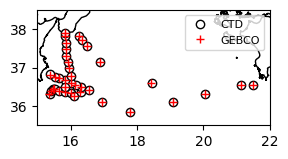

In [51]:
fig , axs =  plt.subplots(1, 1, figsize=(3,1.5))
ax = axs
ax.plot(ITcoast['lonIT'],ITcoast['latIT'],'k-',lw=1)
ax.plot(lon_ctd,lat_ctd,'o',color='w',markersize=6,markeredgecolor='k',lw=.5,label='CTD')
ax.plot(LONG,LATG,'+',color='r',label='GEBCO')
ax.set_xlim([15,22])
ax.set_ylim([35.5,38.5])
ax.legend(fontsize=8,loc=1)

In [52]:
pip install haversine

In [53]:
import haversine as hs

In [54]:
ilon1 = 0
ilat1 = 0

ilon2 = 0
ilat2 = 80

loc1 = [lonG[ilon1],latG[ilat1]]
loc2 = [lonG[ilon2],latG[ilat2]]
delta = hs.haversine(loc1,loc2)
print(delta,'km')

# 24 points = 10 km
# 80 points = 35 km

35.80171436161153 km


In [55]:
di = 24

zG = []
dh = []
dz = []
dzdh = []
VAR_Z = []
VAR10_Z = []

for i in range(0,len(FLON)):
  #print(FLON[i],FLAT[i],FZZG[i])
  flo = FLON[i]
  flonm = flo-di
  flonp = flo+di

  fla = FLAT[i]
  flatm = fla-di
  flatp = fla+di

  ZZ_zone = ZZG[np.arange(flatm,flatp+1),:][:,np.arange(flonm,flonp+1)]
  VAR_Z.append(np.nanvar(ZZ_zone))
  VAR10_Z.append(np.log10(np.nanvar(ZZ_zone)))

  loc0 = np.array([lonG[flo],latG[fla]]).flatten()
  loc1 = np.array([lonG[flo+di],latG[fla+0]]).flatten()
  loc2 = np.array([lonG[flo+di],latG[fla+di]]).flatten()
  loc3 = np.array([lonG[flo+0],latG[fla+di]]).flatten()
  loc4 = np.array([lonG[flo-di],latG[fla+di]]).flatten()
  loc5 = np.array([lonG[flo-di],latG[fla+0]]).flatten()
  loc6 = np.array([lonG[flo-di],latG[fla-di]]).flatten()
  loc7 = np.array([lonG[flo+0],latG[fla-di]]).flatten()
  loc8 = np.array([lonG[flo+di],latG[fla-di]]).flatten()

  zzG0 = ZZG[fla,flo]
  zzG1 = ZZG[fla+0,flo+di]
  zzG2 = ZZG[fla+di,flo+di]
  zzG3 = ZZG[fla+di,flo+0]
  zzG4 = ZZG[fla+di,flo-di]
  zzG5 = ZZG[fla+0,flo-di]
  zzG6 = ZZG[fla-di,flo-di]
  zzG7 = ZZG[fla-di,flo+0]
  zzG8 = ZZG[fla-di,flo+di]
  zG.append([zzG1,zzG2,zzG3,zzG4,zzG5,zzG6,zzG7,zzG8])

  dh1 = hs.haversine(loc0,loc1)
  dh2 = hs.haversine(loc0,loc2)
  dh3 = hs.haversine(loc0,loc3)
  dh4 = hs.haversine(loc0,loc4)
  dh5 = hs.haversine(loc0,loc5)
  dh6 = hs.haversine(loc0,loc6)
  dh7 = hs.haversine(loc0,loc7)
  dh8 = hs.haversine(loc0,loc8)
  dh.append([dh1,dh2,dh3,dh4,dh5,dh6,dh7,dh8])

  dz1 = np.abs(zzG0-zzG1)
  dz2 = np.abs(zzG0-zzG2)
  dz3 = np.abs(zzG0-zzG3)
  dz4 = np.abs(zzG0-zzG4)
  dz5 = np.abs(zzG0-zzG5)
  dz6 = np.abs(zzG0-zzG6)
  dz7 = np.abs(zzG0-zzG7)
  dz8 = np.abs(zzG0-zzG8)
  dz.append([dz1,dz2,dz3,dz4,dz5,dz6,dz7,dz8])

  dzdh.append([dz1/dh1,dz2/dh2,dz3/dh3,dz4/dh4,dz5/dh5,dz6/dh6,dz7/dh7,dz8/dh8])

zG = np.array(zG)
dh = np.array(dh)
dz = np.array(dz)
dzdh = np.array(dzdh)
VAR_Z = np.array(VAR_Z)
VAR10_Z = np.array(VAR10_Z)

In [56]:
FZZG.flatten()

array([ -239,  -198,  -311, -1186, -1186, -3278, -3467, -3462, -3434,
       -3267, -3236, -3534, -4083, -3535, -3207, -4530, -4980, -4032,
       -3297, -3311, -3232, -3278, -2926, -2984, -2324, -3388, -3321,
       -3068, -2980, -2482, -2232, -1886, -1501,  -536, -1390, -2069,
       -2358, -3437])

In [57]:
# Gr1 = 50?
# Gr2 = 50?
# 13 = 60?
# 12 = 75?
# NK17 = 20?
# 3, 11 = -35?
# NK30,NK31,NK32,NK34 = -40?
# NK26,NK27 = -25?
# NK21,NK22,NK23,NK24,NK25 = -65?
# NK18,NK15,NK14,NK13,NK12,NK11,NK10,NK1 = -75?
# NK8b,NK6,NK4, NK2,KM3,KM4 = -85?

In [58]:
dirflows = [99999, 99999, 99999, 99999, -85, -85, 99999, -85, -85,
       -85,  -75, -35, -35, 75, 60, 50, 50, 20,  -75,
        -75,  -75,  -75,  -75,  -75,  -75, -85, -65,
       -65, -65, -65, -65, -25, -25, 99999, -40,
       -40, -40, -40]

np.unique(dirflows)

poiflows = []
idiflows = []
for i in range(0,len(dirflows)):
  d = dirflows[i]
  if    d == -85 : p = np.array([5])
  elif  d == -75 : p = np.array([4,5])
  elif  d == -65 : p = np.array([4,5])
  elif  d == -45 : p = np.array([4])
  elif  d == -35 : p = np.array([4])
  elif  d == -25 : p = np.array([3,4])
  elif  d ==  20 : p = np.array([2,3])
  elif  d ==  50 : p = np.array([2])
  elif  d ==  60 : p = np.array([1,2])
  elif  d ==  75 : p = np.array([1,2])
  elif  d ==  99999 : p = np.array([1,2,3,4,5,6,7,8])

  poiflows.append(p)
  idiflows.append(p-1)



In [59]:
DZDH = []
for i in range(0,len(sta)):
  idx = idiflows[i]
  vals = np.array(dzdh[i,:].flatten())
  DZDH.append( np.nanmean(vals[idx]) )
DZDH = np.array(DZDH)

In [60]:
SLOP_gebco = DZDH.flatten()
BTTD_gebco = FZZG.flatten()
ROGH_gebco = VAR_Z.flatten()
ROGH10_gebco = VAR10_Z.flatten()



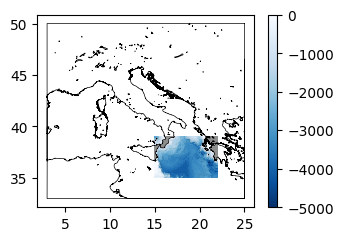

In [61]:
import matplotlib.colors as mcolors
from matplotlib import colors

colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))

colors2 = plt.cm.terrain(np.linspace(0, 1, 128))
colors2 = colors2[31:108,:]

colors2 = np.array([141, 143, 142, 255])/255
colors3 = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors3)
cmap = mymap

#cmap = 'Blues_r'
#norm = colors.BoundaryNorm(-5000,0, cmap.N)

fig , axs =  plt.subplots(1, 1, figsize=(3.5,2.5))
ax = axs
c = ax.pcolor(XX,YY,ZZ, cmap=cmap, vmin=-5000, vmax=0, shading='auto',label='')
fig.colorbar(c, ax=ax)
cs = ax.contour(XX,YY,ZZ,levels= np.arange(-5000,0,500),colors='k', linewidths=0.01, linestyles='solid' )
cs = ax.contour(XX,YY,ZZ,levels= np.arange(-5000,0,1000),colors='k', linewidths=0.02, linestyles='solid' )
ax.plot(ITcoast['lonIT'],ITcoast['latIT'],'k-',lw=0.5)

# Figure: Rw lon lat

In [62]:
MARKERS = np.array(['.', '.', '.', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o',
       'o', 'o', 'o', 'o', 'o', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'o',
       's', 's', 's', 's', 's', 's', 's', 's', '^', '^', '^', '^'])


In [63]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# Définitions
colors_list = [(161, 213, 255),
               #(116, 237, 148),  # GREENS
               (8, 194, 58),

              (255, 255, 105),
              (255, 239, 15),  # YELLOWS
              (255, 208, 0),

              (255, 162, 0),
              (255, 119, 0), # ORANGES
              (255, 85, 0),

              (250, 27, 135),
              (235, 54, 255),  # REDS
               (162, 62, 250),
               ]
pseudo_hsv_cmap = colors.LinearSegmentedColormap.from_list('my_colormap', (np.array(colors_list)/255), N=256)


colorbar_range = np.arange(3, 42-3, 3)-1.5
print(colorbar_range+1.5)

[ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30. 33. 36.]


rw_x_y


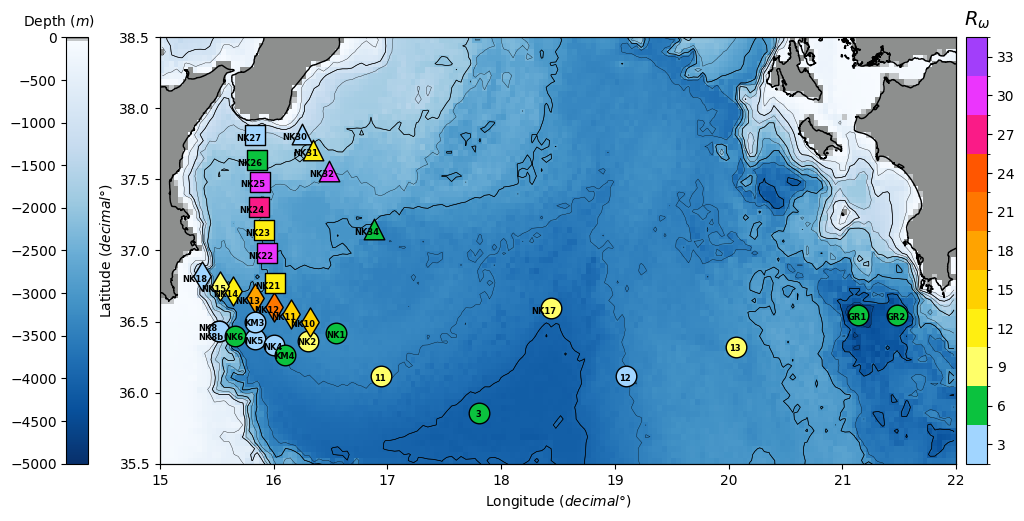

In [66]:
import matplotlib.colors as mcolors
from matplotlib import colors

colors1 = plt.cm.Blues_r(np.linspace(0., 1, 128))
colors2 = plt.cm.terrain(np.linspace(0, 1, 128))
colors2 = colors2[31:108,:]
colors2 = np.array([141, 143, 142, 255])/255
colors3 = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors3)
cmap_bathy = mymap

cmap = pseudo_hsv_cmap
norm = colors.BoundaryNorm(colorbar_range, cmap.N)

###
fig, ax = plt.subplots(1, 1,figsize=(12,5))
clr_text = 'k'
BATHYBLUE = 1
if BATHYBLUE == 1:
  c = ax.pcolor(XX,YY,ZZ, cmap=cmap_bathy, vmin=-5000, vmax=0, shading='auto',label='')
  fig.colorbar(c, ax=ax,ticks=np.arange(-5000,500,500),location='left',pad=0.06)
  clr_text = 'w'

cs = ax.contour(XX,YY,ZZ,levels= np.arange(-5000,0,500),colors='k', linewidths=0.25, linestyles='solid' )
cs = ax.contour(XX,YY,ZZ,levels= np.arange(-5000,0,1000),colors='k', linewidths=0.5, linestyles='solid' )
ax.plot(ITcoast['lonIT'],ITcoast['latIT'],'k-',lw=1)
t_str = '$R_w$'

ax2 = ax.twiny()
for i in range(0,len(lon_ctd)):
    if MARKERS[i] == '^': clr_marker = 'm'
    elif MARKERS[i] == 's': clr_marker = 'r'
    elif MARKERS[i] == 'o': clr_marker = 'b'
    elif MARKERS[i] == 'd': clr_marker = 'orange'
    elif MARKERS[i] == '.': clr_marker = 'k'

    if (np.isfinite(rw1[i])==True): # & (sta[i] !='NK5'): #------------

      c = ax2.scatter(lon_ctd[i],lat_ctd[i],220,rw1[i],cmap=cmap,norm=norm,marker=MARKERS[i],edgecolors='k',linewidths=1)
      #if (MARKERS[i] == 'o') | (MARKERS[i] == 'd'):
      #  ax2.text(lon_ctd[i]-0.24,lat_ctd[i]-0.10,sta[i],fontsize=6,color=clr_text,fontweight='bold')
      #else:
      clr_text = 'k'
      if len(sta[i])>3: deltalon = -0.17 ; deltalat = -0.04
      elif len(sta[i])==3: deltalon = -0.09 ; deltalat = -0.03
      elif len(sta[i])==2: deltalon = -0.06 ; deltalat = -0.03
      elif len(sta[i])==1: deltalon = -0.03 ; deltalat = -0.03


      #if (sta[i] =='NK5') :  deltalon = -0.15 ; deltalat = -0.08
      #elif (sta[i] =='NK4') :  deltalon = -0.17 ; deltalat = -0.10
      if (sta[i] =='NK8') :  deltalon = -0.18  ; deltalat = -0.03+0.03
      elif (sta[i] =='NK8b') :  deltalon = -0.18  ; deltalat = -0.03-0.03

      ax2.text(lon_ctd[i]+deltalon,lat_ctd[i]+deltalat,sta[i],fontsize=6,color=clr_text,fontweight='bold')
fig.colorbar(c, ax=ax2,ticks=colorbar_range+1.5,pad=0.01)
ax2.text(22.07,38.58,'$R_\omega$',fontsize=14)
ax2.text(13.80,38.58,'Depth $(m)$',fontsize=10)


ax.set_xlabel('Longitude $(decimal \degree)$', fontsize=10)
ax.set_ylabel('Latitude $(decimal \degree)$', fontsize=10)
ax.set_xlim([15,22])
ax.set_ylim([35.5,38.5])

ax2.set_xlim([15,22])
ax2.set_ylim([35.5,38.5])
ax2.set_xticks([])
#ax.set_title(t_str,fontsize=14,loc='right')

# - - - - - - - - -
fig.tight_layout(pad=0)
fig_filename = 'rw_x_y'

plt.savefig(fig_filename+'.pdf')
plt.savefig(fig_filename+'.png',dpi=600)
print(fig_filename)


In [ ]:
files.download(fig_filename+'.pdf')
files.download(fig_filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Figure: Pannels

rw_slope


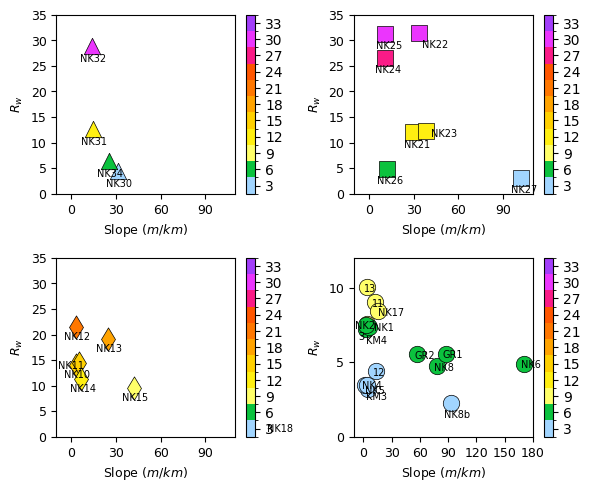

In [68]:
import matplotlib.colors as mcolors
from matplotlib import colors

cmap = pseudo_hsv_cmap
norm = colors.BoundaryNorm(colorbar_range, cmap.N)

fig, axs = plt.subplots(2, 2,figsize=(6,5))
t_str = '$R_w$'
for i in range(0,len(lon_ctd)):
  if (sta[i]!='NK28'): #  & (sta[i]!='NK5'):
    if MARKERS[i] == '^': clr_marker = 'm' ; k = 0; l=0
    elif MARKERS[i] == 'd': clr_marker = 'r'; k = 1; l=0
    elif MARKERS[i] == 's': clr_marker = 'b'; k = 0; l=1
    elif MARKERS[i] == 'o': clr_marker = 'orange' ; k = 1; l=1
    elif MARKERS[i] == '.': clr_marker = 'k'  ; k = 1; l=1

    ax = axs[k,l]

    if MARKERS[i] == '^': deltax = -8 ; deltay = -3
    elif MARKERS[i] == 'd': deltax = -8 ; deltay = -2.5
    elif MARKERS[i] == 's': deltax = -7 ; deltay = -3
    elif MARKERS[i] == 'o': deltax = -7 ; deltay = -1

    if sta[i] == 'NK11': deltax = -14 ; deltay = -1

    if sta[i] == 'NK25': deltax = -6 ; deltay = -3
    if sta[i] == 'NK22': deltax = +2 ; deltay = -3
    if sta[i] == 'NK21': deltax = -6 ; deltay = -3
    if sta[i] == 'NK23': deltax = +3 ; deltay = -1

    if len(sta[i]) == 2: deltax = -3 ; deltay = -0.30
    if len(sta[i]) == 3: deltax = -3 ; deltay = -0.30

    if sta[i] == 'KM4': deltax = 0 ; deltay = -1
    if sta[i] == 'KM3': deltax = -.5 ; deltay = -1
    if sta[i] == 'NK17': deltax = 0 ; deltay = -0.30
    if sta[i] == 'NK1': deltax = +5 ; deltay = -0.3
    if sta[i] == 'NK2': deltax = -13 ; deltay = -0.3
    if sta[i] == '3': deltax = -8 ; deltay = -1

    if np.isfinite(rw1[i])==True:
      c = ax.scatter(SLOP_gebco[i],rw1[i],140,rw1[i],cmap=cmap,norm=norm,marker=MARKERS[i],edgecolors='k',linewidths=.5)
      ax.text(SLOP_gebco[i]+deltax,rw1[i]+deltay,sta[i],fontsize=7)

    ax.set_xlabel('Slope $(m/km)$', fontsize=9)
    ax.set_ylabel('$R_w$', fontsize=9)
    ax.set_xticks(np.arange(0,180+1,30))
    ax.set_xticklabels(np.arange(0,180+1,30),fontsize=9)

    ax.set_yticks(np.arange(0,35+1,5))
    ax.set_yticklabels(np.arange(0,35+1,5),fontsize=9)

    ax.set_xlim([-10,150])
    ax.set_ylim([0,40])

    if MARKERS[i] == '^': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    elif MARKERS[i] == 'd': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    elif MARKERS[i] == 's': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    elif MARKERS[i] == 'o': ax.set_xlim([-10,180]); ax.set_ylim([0,12])

    #if MARKERS[i] == '^': ax.set_xlim([-10,110]); ax.set_ylim([0,45])
    #elif MARKERS[i] == 'd': ax.set_xlim([-10,110]); ax.set_ylim([0,45])
    #elif MARKERS[i] == 's': ax.set_xlim([-10,110]); ax.set_ylim([0,45])
    #elif MARKERS[i] == 'o': ax.set_xlim([-10,180]); ax.set_ylim([0,25])

    #ax.set_title(t_str,fontsize=13)

for k in range(0,1+1):
  for l in range(0,1+1):
    ax = axs[k,l]
    fig.colorbar(c, ax=ax,ticks=colorbar_range+1.5)


fig.tight_layout(pad = 1)
fig_filename = 'rw_slope'
plt.savefig(fig_filename+'.pdf')
plt.savefig(fig_filename+'.png',dpi=600)
print(fig_filename)

In [ ]:
files.download(fig_filename+'.pdf')
files.download(fig_filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rw_rough


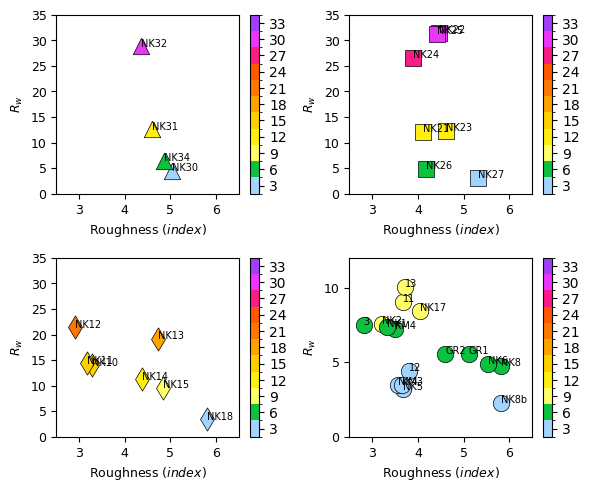

In [69]:
import matplotlib.colors as mcolors
from matplotlib import colors

cmap = pseudo_hsv_cmap
norm = colors.BoundaryNorm(colorbar_range, cmap.N)

fig, axs = plt.subplots(2, 2,figsize=(6,5))
t_str = '$R_w$'
for i in range(0,len(lon_ctd)):
  if (sta[i]!='NK28'): #  & (sta[i]!='NK5'):
    if MARKERS[i] == '^': clr_marker = 'm' ; k = 0; l=0
    elif MARKERS[i] == 'd': clr_marker = 'r'; k = 1; l=0
    elif MARKERS[i] == 's': clr_marker = 'b'; k = 0; l=1
    elif MARKERS[i] == 'o': clr_marker = 'orange' ; k = 1; l=1
    elif MARKERS[i] == '.': clr_marker = 'k'  ; k = 1; l=1

    ax = axs[k,l]

    #if MARKERS[i] == '^': deltax = -8 ; deltay = -3
    #elif MARKERS[i] == 'd': deltax = -8 ; deltay = -2.5
    #elif MARKERS[i] == 's': deltax = -7 ; deltay = -3
    #elif MARKERS[i] == 'o': deltax = -7 ; deltay = -1

    #if sta[i] == 'NK11': deltax = -14 ; deltay = -1

    #if sta[i] == 'NK25': deltax = -6 ; deltay = -3
    #if sta[i] == 'NK22': deltax = +2 ; deltay = -3
    #if sta[i] == 'NK21': deltax = -6 ; deltay = -3
    #if sta[i] == 'NK23': deltax = +3 ; deltay = -1

    #if len(sta[i]) == 2: deltax = -3 ; deltay = -0.30
    #if len(sta[i]) == 3: deltax = -3 ; deltay = -0.30

    #if sta[i] == 'KM4': deltax = 0 ; deltay = -1
    #if sta[i] == 'KM3': deltax = -.5 ; deltay = -1
    #if sta[i] == 'NK17': deltax = 0 ; deltay = -0.30
    #if sta[i] == 'NK1': deltax = +5 ; deltay = -0.3
    #if sta[i] == 'NK2': deltax = -13 ; deltay = -0.3
    #if sta[i] == '3': deltax = -8 ; deltay = -1

    deltax = 0
    deltay = 0

    if np.isfinite(rw1[i])==True:
      c = ax.scatter(ROGH10_gebco[i],rw1[i],140,rw1[i],cmap=cmap,norm=norm,marker=MARKERS[i],edgecolors='k',linewidths=.5)
      ax.text(ROGH10_gebco[i]+deltax,rw1[i]+deltay,sta[i],fontsize=7)

    ax.set_xlabel('Roughness $(index)$', fontsize=9)
    ax.set_ylabel('$R_w$', fontsize=9)
    ax.set_xticks(np.arange(2,6+1,1))
    ax.set_xticklabels(np.arange(2,6+1,1),fontsize=9)

    ax.set_yticks(np.arange(0,35+1,5))
    ax.set_yticklabels(np.arange(0,35+1,5),fontsize=9)

    ax.set_xlim([2.5,6.5])
    ax.set_ylim([0,35])

    #if MARKERS[i] == '^': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    #elif MARKERS[i] == 'd': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    #elif MARKERS[i] == 's': ax.set_xlim([-10,110]); ax.set_ylim([0,35])
    #elif MARKERS[i] == 'o': ax.set_xlim([-10,160]); ax.set_ylim([0,15])

    if MARKERS[i] == 'o':  ax.set_ylim([0,12])

    #ax.set_title(t_str,fontsize=13)

for k in range(0,1+1):
  for l in range(0,1+1):
    ax = axs[k,l]
    fig.colorbar(c, ax=ax,ticks=colorbar_range+1.5)


fig.tight_layout(pad = 1)
fig_filename = 'rw_rough'
plt.savefig(fig_filename+'.pdf')
plt.savefig(fig_filename+'.png',dpi=600)
print(fig_filename)

In [ ]:
files.download(fig_filename+'.pdf')
files.download(fig_filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Figure: Rw boxplots
##### from the 1m-rolling windows of 320m of data

In [70]:
clr_grey = '#000000'
colorss = [clr_grey,clr_grey,clr_grey]
c0 = dict(color=colorss[0])
c1 = dict(color=colorss[1])
c2 = dict(color=colorss[2])

In [71]:
MU = np.unique(MARKERS)
ORD = []
for u in range(0,len(MU)):
  f = np.where(MARKERS == MU[u])[0]
  ORD = ORD + list(f)
ORD = np.array(ORD)
ORD

MU
MU = ['.', '^', 's', 'd', 'o']

[0, 1, 2]
[3, 4, 5, 6]
[7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19, 20]
[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
rw_boxplots_synth


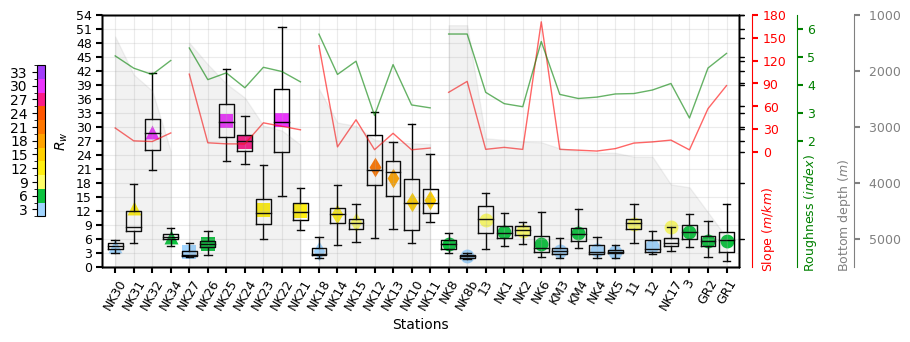

In [72]:
import matplotlib.colors as mcolors
from matplotlib import colors
cmap = pseudo_hsv_cmap
norm = colors.BoundaryNorm(colorbar_range, cmap.N)

fig, axs = plt.subplots(1, 1, figsize=(10,3.5))
ax = axs
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#MU = np.unique(MARKERS)
MU = ['.', '^', 's', 'd', 'o']
I = -1
sta_str = []
for u in range(0,len(MU)):
  fu = np.where(MARKERS == MU[u])[0] # on classe par groupes de markers
  #achso = np.argsort(np.array(INFOS.iloc[fu,:])[:,5]) # on reclasse par DISTH: 4 BOTTOMDEPTH:5
  achso = np.argsort(np.abs(BTTD_gebco[fu]))
  fu = fu[achso]

  #paramslop = np.array(INFOS.iloc[fu,:])[:,2]
  #paramboth = np.array(INFOS.iloc[fu,:])[:,5]
  #paramroug = np.array(INFOS.iloc[fu,:])[:,3]

  paramslop = SLOP_gebco[fu]
  paramboth = np.abs(BTTD_gebco[fu])
  paramroug = ROGH10_gebco[fu]

  J = []
  S = []
  B = []
  R = []
  for i in range(0,len(fu)):
      if (sta[fu[i]]!='NK28'): # & (sta[fu[i]]!='NK5'):

        I = I+1
        J.append(I)
        S.append(paramslop[i])
        B.append(paramboth[i])
        R.append(paramroug[i])
        fsta = np.where(META[:,0]==fu[i])[0]
        len(fsta)
        if (len(fsta)>0): # & (sta[fu[i]]!='NK28'):

            df = pd.DataFrame(RW1[fsta])
            posi = I
            labels = ['']
            p = 0
            wdth = .8
            ax.boxplot(df, positions=[posi],labels=[labels[0]],vert=True,showfliers=False,
                      widths=wdth,boxprops=dict(color=colorss[p]),whiskerprops=dict(color=colorss[p]),
                              capprops=dict(color=colorss[p]),medianprops=dict(color=colorss[p]))
            #ax.plot(i,rw1[i],marker=MARKERS[i],color='k',markersize=7,markeredgewidth=1,alpha=1,markerfacecolor='w')
        #ax.plot(I,rw1[fu[i]],marker=MARKERS[fu[i]],color='k',markersize=10,markeredgewidth=1,alpha=1,markerfacecolor='w')
        c = ax.scatter(I,rw1[fu[i]],100,rw1[fu[i]],cmap=cmap,norm=norm,marker=MARKERS[fu[i]],edgecolors='k',linewidths=0)
        sta_str.append(sta[fu[i]])
        ax.set_yticks(np.arange(0,66+1,3))
        ax.set_yticklabels([])

  print(J)
  #ax.axvspan(J[0]-0.3, J[-1]+0.3, ymin=0, ymax=1, color='k',alpha=0.055)


  ax2 = ax.twinx()

  ax2.plot(np.array(J),np.array(S),'-',color='r',lw=1,alpha=.6)
  ax2.set_yticks(np.arange(0,180+1,30))
  ax2.set_yticklabels([])
  ax2.set_ylim(-150,180)

  ax3 = ax.twinx()
  ax3.fill_between(np.array(J),5500,np.array(B),color='gray',alpha=.1)
  ax3.set_yticks(np.arange(0,6000,1000))
  ax3.set_yticklabels([])
  ax3.set_ylim(1000,5500)
  ax3.invert_yaxis()

  ax4 = ax.twinx()
  ax4.plot(np.array(J),np.array(R),'-',color='g',lw=1,alpha=.6)
  ax4.set_yticks(np.arange(2,7,1))
  ax4.set_yticklabels([])
  ax4.set_ylim(-2.5,6.5)

ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)


ax2.spines["right"].set_position(("axes", 1.02))
ax2.set_yticklabels(np.arange(0,180+1,30),fontsize=9,color='r')
ax2.set_yticks(np.arange(0,180+1,30))
#ax2.set_ylabel('Slope $(m/km)$',fontsize=9)
ax2.text(37.8,-150,'Slope $(m/km)$',fontsize=9,color='r',rotation=90)
ax2.set_ylim(-150,180)

ax3.spines["right"].set_position(("axes", 1.18))
ax3.set_yticks(np.arange(0,6000,1000))
ax3.set_yticklabels([' 0',' 1000', ' 2000', ' 3000', ' 4000', ' 5000'],fontsize=9)
ax3.set_ylim(1000,5500)
ax3.invert_yaxis()
#ax3.set_ylabel('Bottom depth $(m)$',fontsize=9,color='gray')
ax3.text(41.9,5500,'Bottom depth $(m)$',fontsize=9,color='gray',rotation=90)

ax4.spines["right"].set_position(("axes", 1.09))
ax4.set_yticks(np.arange(2,7,1))
ax4.set_yticklabels(np.arange(2,7,1),color='g',fontsize=9)
ax4.text(40.1,-2.5,'Roughness $(index)$',fontsize=9,color='g',rotation=90)
ax4.set_ylim(2.5,6.5)
ax4.set_ylim(-2.5,6.5)

ax.yaxis.label.set_color('k')
ax2.yaxis.label.set_color('r')
ax3.yaxis.label.set_color('gray')
ax4.yaxis.label.set_color('g')

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='y', colors='r', **tkw)
ax3.tick_params(axis='y', colors='gray', **tkw)
ax4.tick_params(axis='y', colors='g', **tkw)
ax.tick_params(axis='x', **tkw)

ax.spines['left'].set_edgecolor('k')
ax2.spines['right'].set_edgecolor('r')
ax3.spines['right'].set_edgecolor('gray')
ax4.spines['right'].set_edgecolor('g')


ax.set_xticks(np.arange(0,len(sta_str),1))
ax.set_xticklabels(sta_str,rotation=60,fontsize=9)
ax.set_ylabel('$R_w$')
ax.set_xlabel('Stations')
ax.grid(alpha=.25)
ax.set_xlim(2.3,36.7)
ax.set_yticks(np.arange(0,66+1,3))
ax.set_yticklabels(np.arange(0,66+1,3),fontsize=9)
ax.set_ylim(0,54)

fig.colorbar(c, ax=ax4,ticks=colorbar_range+1.5,location='left',pad=0.07,shrink=3/5)

fig.tight_layout(pad=1)
fig_filename = 'rw_boxplots_synth'
plt.savefig(fig_filename+'.pdf')
plt.savefig(fig_filename+'.png',dpi=600)
print(fig_filename)


In [ ]:
files.download(fig_filename+'.pdf')
files.download(fig_filename+'.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Figure: Spectra
##### Plot all spectra in each window (640m: 320m FFT length, translated upward of 1m, from the deepest data toward the surface, 320 times)

Station NK8    index:3    imin:522    imax:1161    zmax:1162m


spectra_station_NK8
Station NK8b    index:4    imin:530    imax:1169    zmax:1170m


spectra_station_NK8b
Station NK6    index:5    imin:2650    imax:3289    zmax:3290m


spectra_station_NK6
Station NK5    index:6    imin:2799    imax:3438    zmax:3439m


spectra_station_NK5
Station NK4    index:7    imin:2751    imax:3390    zmax:3391m


spectra_station_NK4
Station KM4    index:8    imin:2752    imax:3391    zmax:3392m


spectra_station_KM4
Station NK2    index:9    imin:2591    imax:3230    zmax:3231m


spectra_station_NK2
Station NK1    index:10    imin:2561    imax:3200    zmax:3201m


spectra_station_NK1
Station 11    index:11    imin:2802    imax:3441    zmax:3442m


spectra_station_11
Station 3    index:12    imin:3418    imax:4057    zmax:4058m


spectra_station_3
Station 12    index:13    imin:2839    imax:3478    zmax:3479m


spectra_station_12
Station 13    index:14    imin:2500    imax:3139    zmax:3140m


spectra_station_13
Station GR2    index:15    imin:3767    imax:4406    zmax:4407m


spectra_station_GR2
Station GR1    index:16    imin:4205    imax:4844    zmax:4845m


spectra_station_GR1
Station NK17    index:17    imin:3379    imax:4018    zmax:4019m


spectra_station_NK17
Station NK10    index:18    imin:2621    imax:3260    zmax:3261m


spectra_station_NK10
Station NK11    index:19    imin:2651    imax:3290    zmax:3291m


spectra_station_NK11
Station NK12    index:20    imin:2571    imax:3210    zmax:3211m


spectra_station_NK12
Station NK13    index:21    imin:2615    imax:3254    zmax:3255m


spectra_station_NK13
Station NK14    index:22    imin:2251    imax:2890    zmax:2891m


<ipython-input-81-3a3f6360fba3>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig , axs =  plt.subplots(1, 1, figsize=(6,4))


spectra_station_NK14
Station NK15    index:23    imin:2265    imax:2904    zmax:2905m


spectra_station_NK15
Station NK18    index:24    imin:1655    imax:2294    zmax:2295m


spectra_station_NK18
Station KM3    index:25    imin:2731    imax:3370    zmax:3371m


spectra_station_KM3
Station NK21    index:26    imin:2661    imax:3300    zmax:3301m


spectra_station_NK21
Station NK22    index:27    imin:2381    imax:3020    zmax:3021m


spectra_station_NK22
Station NK23    index:28    imin:2301    imax:2940    zmax:2941m


spectra_station_NK23
Station NK24    index:29    imin:1821    imax:2460    zmax:2461m


spectra_station_NK24
Station NK25    index:30    imin:1580    imax:2219    zmax:2220m


spectra_station_NK25
Station NK26    index:31    imin:1241    imax:1880    zmax:1881m


spectra_station_NK26
Station NK27    index:32    imin:831    imax:1470    zmax:1471m


spectra_station_NK27
Station NK30    index:34    imin:727    imax:1366    zmax:1367m


spectra_station_NK30
Station NK31    index:35    imin:1411    imax:2050    zmax:2051m


spectra_station_NK31
Station NK32    index:36    imin:1691    imax:2330    zmax:2331m


spectra_station_NK32
Station NK34    index:37    imin:2746    imax:3385    zmax:3386m
spectra_station_NK34


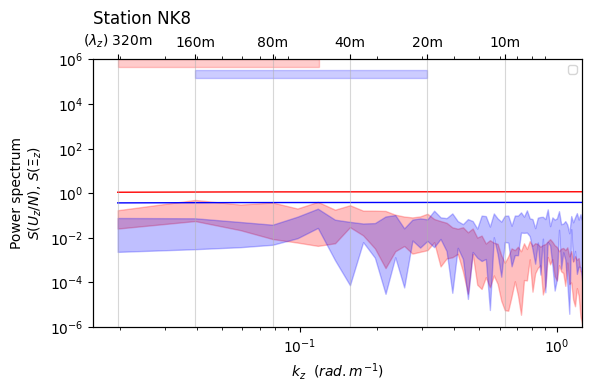

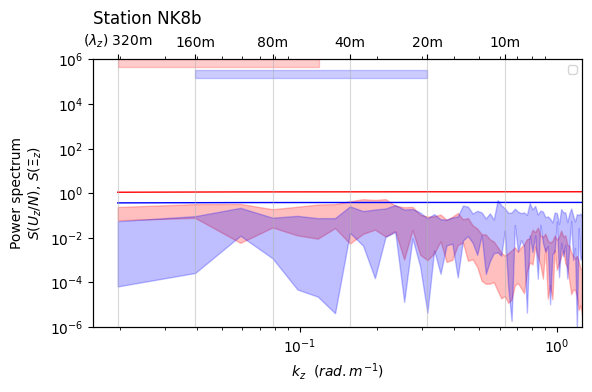

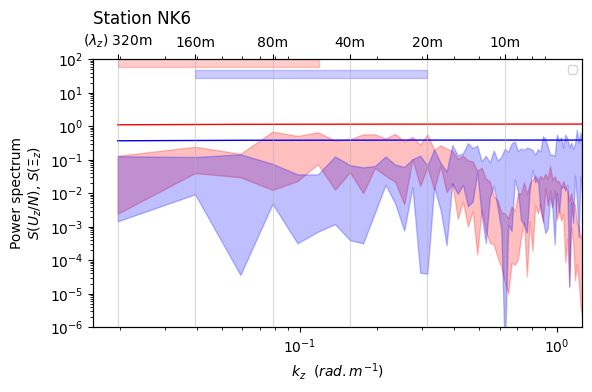

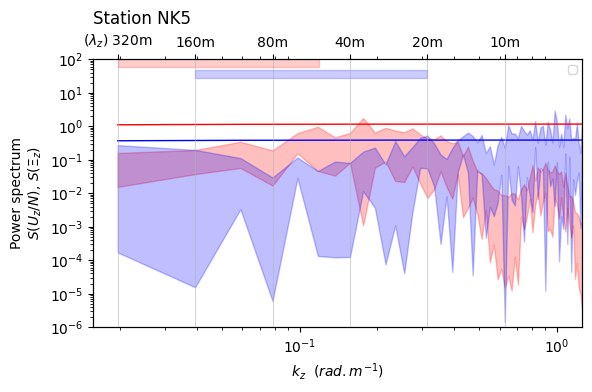

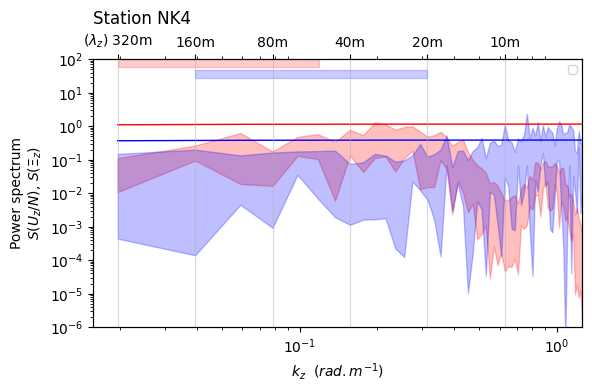

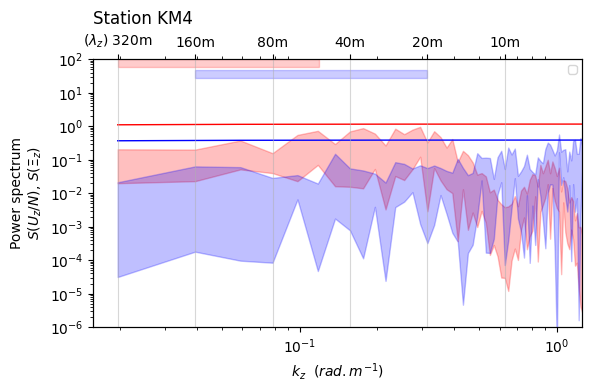

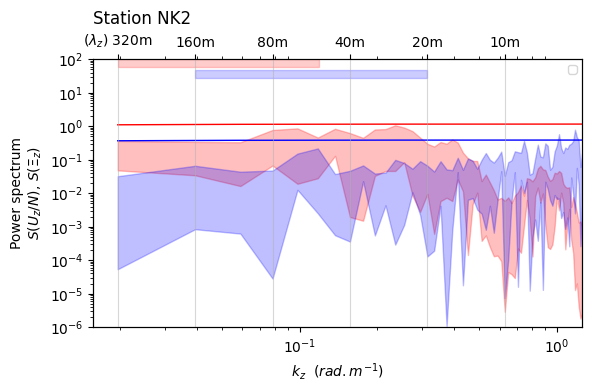

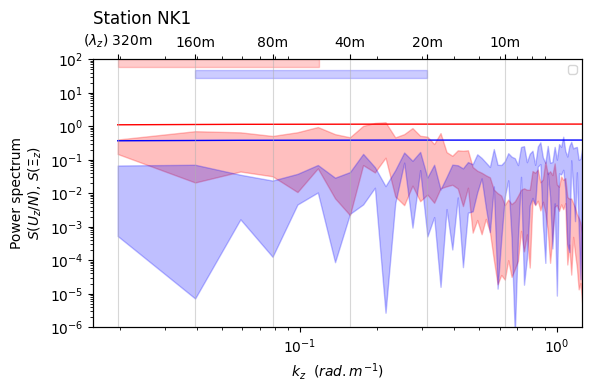

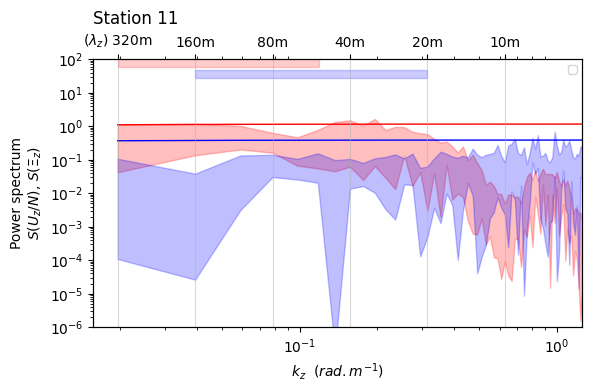

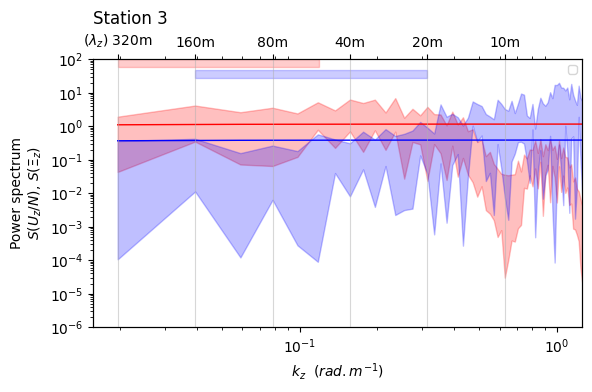

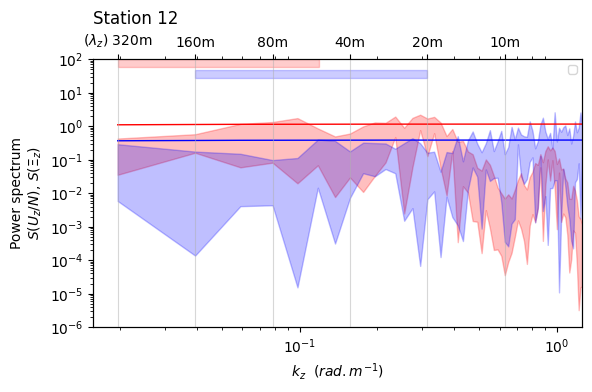

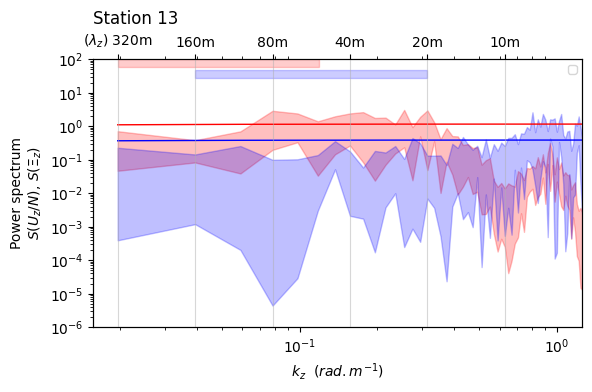

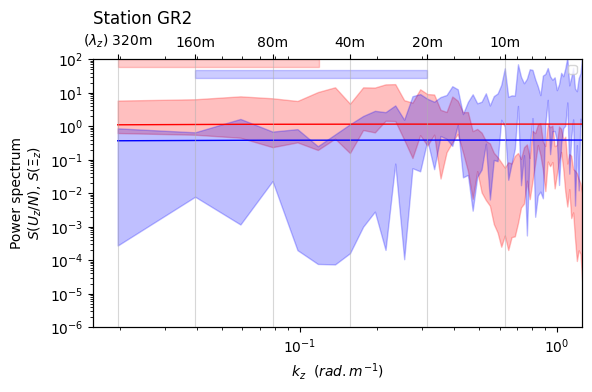

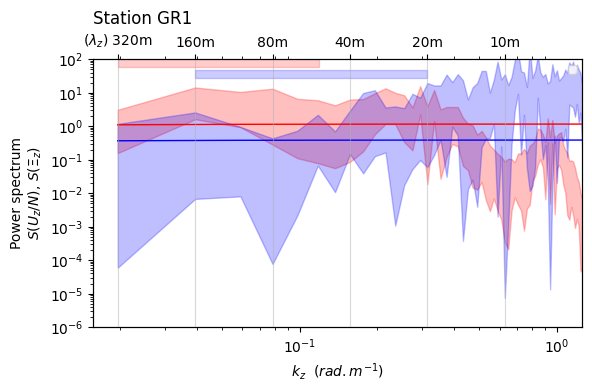

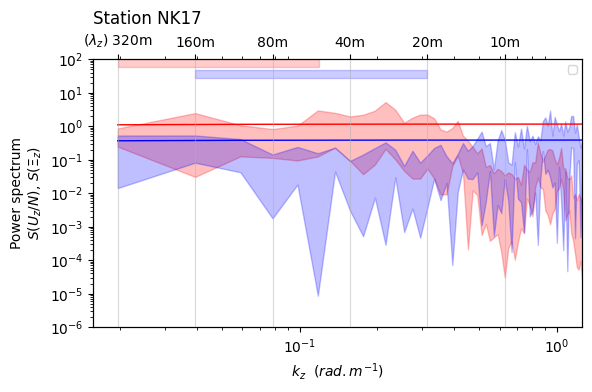

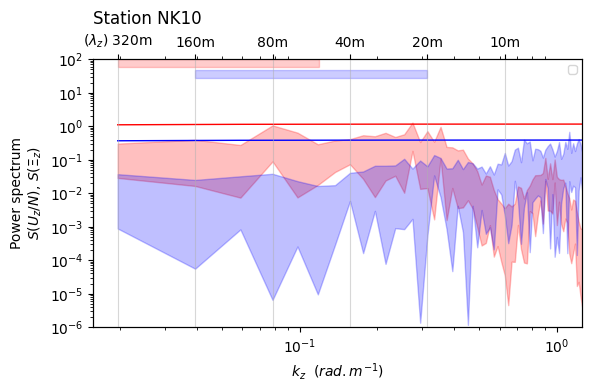

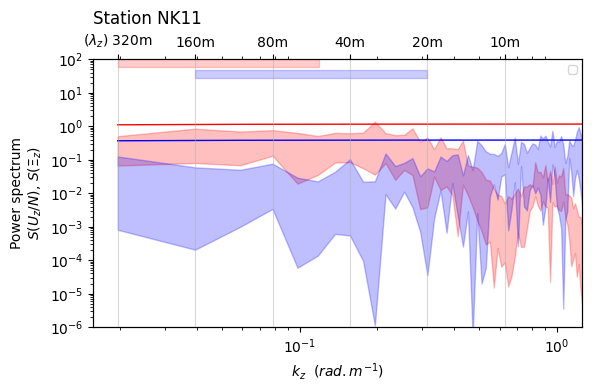

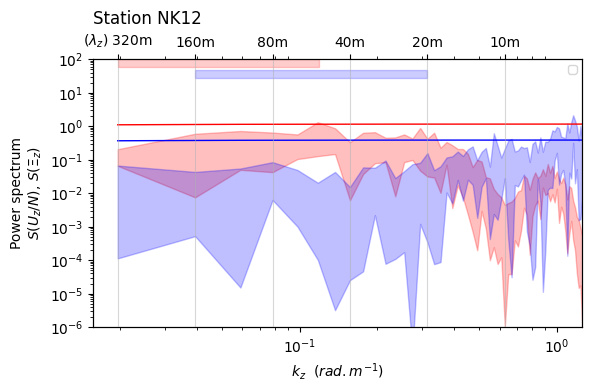

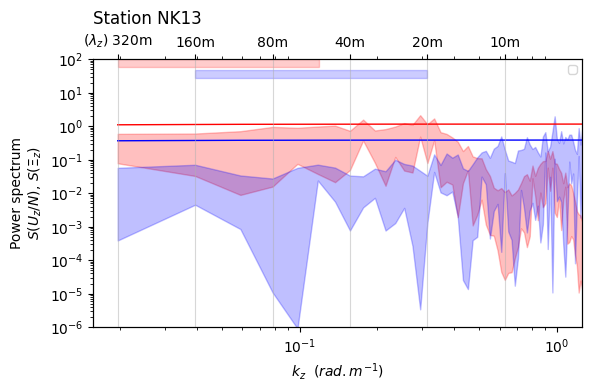

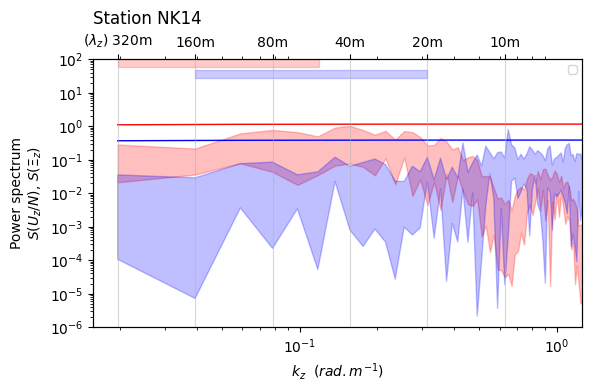

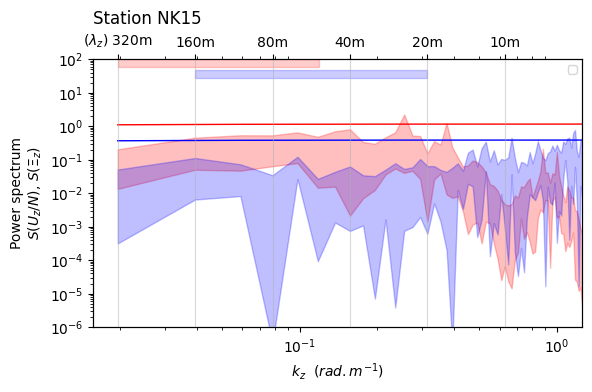

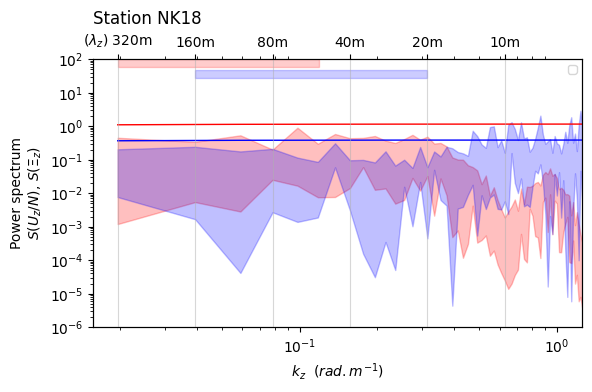

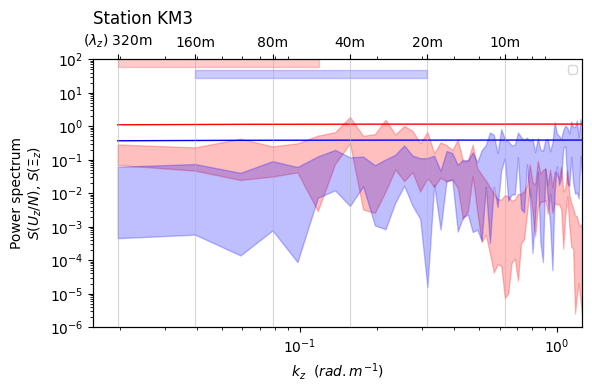

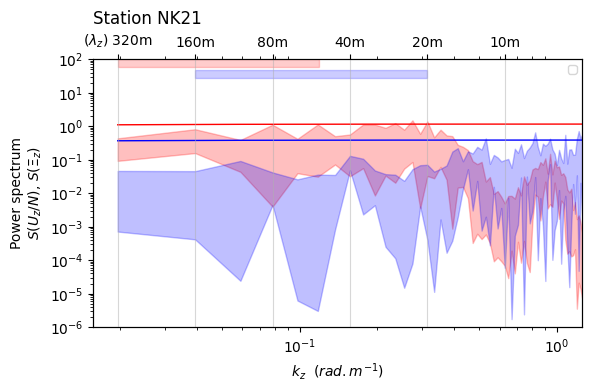

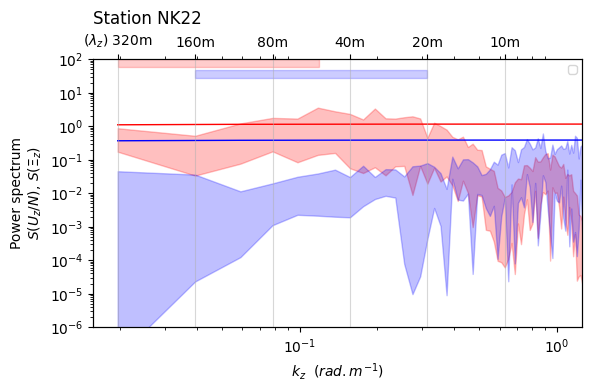

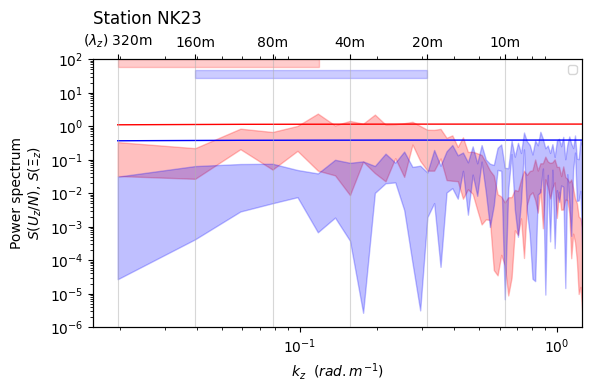

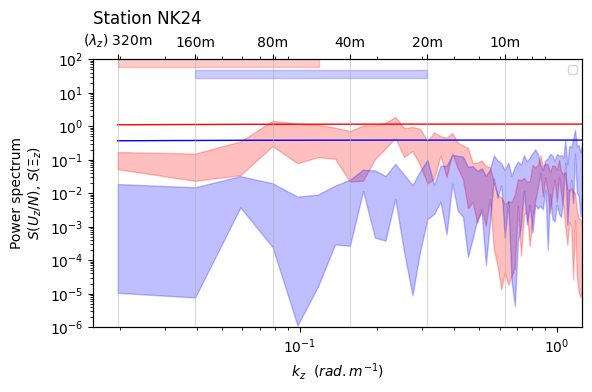

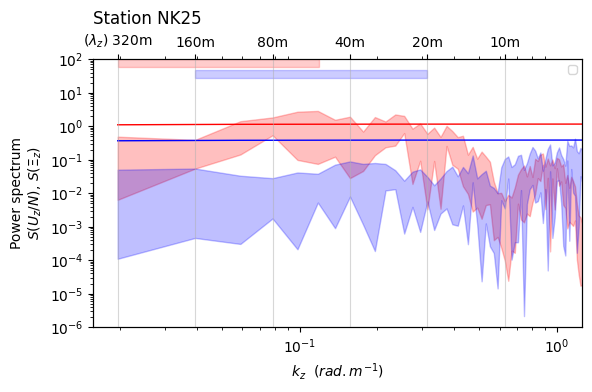

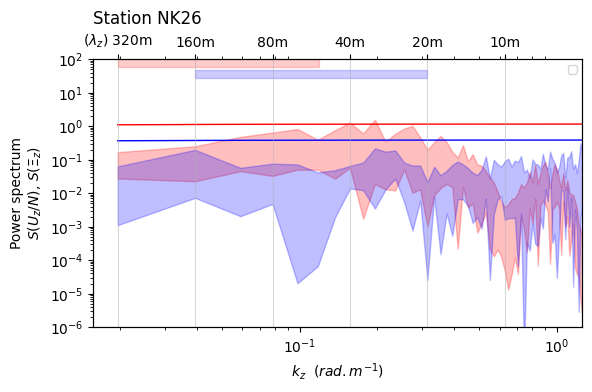

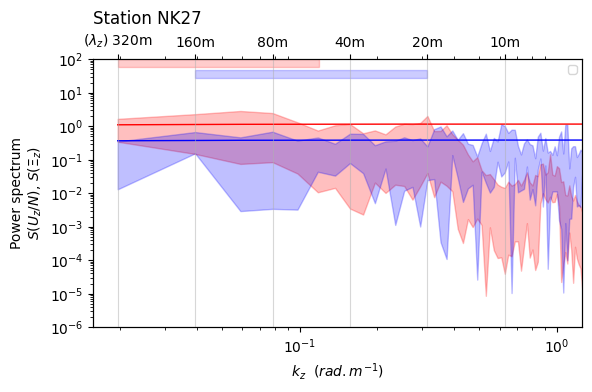

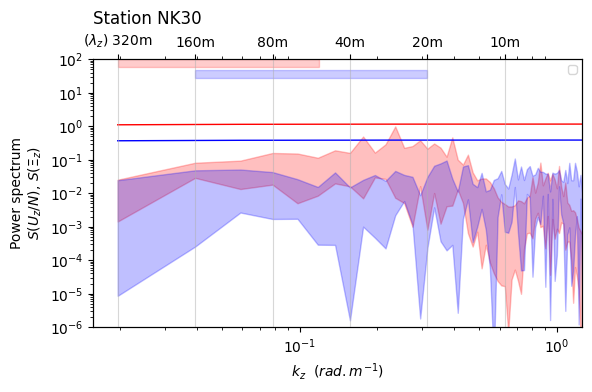

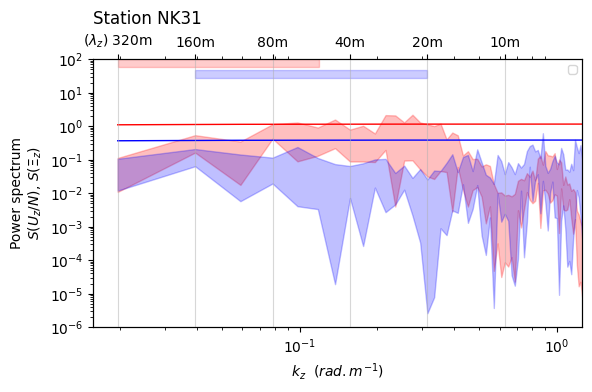

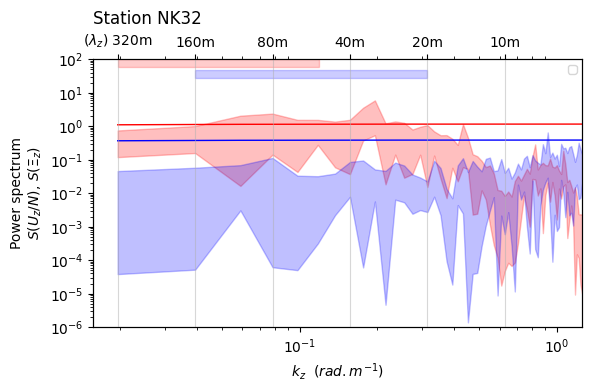

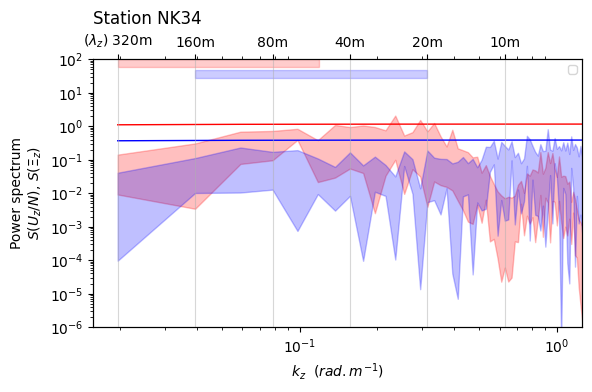

In [81]:
for iprofile in range(0,len(sta)):
    fp = np.where(META[:,0]==iprofile)[0]
    if len(fp)>0:
        print('Station '+str(sta[iprofile])+'    index:'+str(iprofile)+'    imin:'+str(int(np.nanmin(META[fp,2])))+'    imax:'+str(int(np.nanmax(META[fp,3])))+'    zmax:'+str(int(np.nanmax(D_in[:,iprofile])))+'m')

        fig , axs =  plt.subplots(1, 1, figsize=(6,4))
        ax = axs
        #
        #ax.set_title('Station '+str(sta[iprofile])+'    index:'+str(iprofile)+'    imin:'+str(int(np.nanmin(META[fp,2])))+'    imax:'+str(int(np.nanmax(META[fp,3])))+'    zmax:'+str(int(np.nanmax(D_in[:,iprofile])))+'m')
        ax.set_title('Station '+str(sta[iprofile]),loc='left')

        limy1 = 1e-6
        limy2 = 1e2
        if (sta[iprofile] == 'NK8') or (sta[iprofile] == 'NK8b'):
            limy2 = 1e6
        LZplot = np.array([320,160,80,50,40,30,20,10,2])
        #
        ax.axvspan(2*np.pi/LZround[lsta_shear], 2*np.pi/LZround[lend_shear], ymin=0.97, ymax=1, color='r',alpha=0.2)
        ax.axvspan(2*np.pi/LZround[lsta_strain], 2*np.pi/LZround[lend_strain], ymin=0.93, ymax=0.96, color='b',alpha=0.2)
        #
        #
        psd_shear_min = []
        psd_shear_max = []
        psd_strain_min = []
        psd_strain_max = []
        for l in range(0,len(KZ)):
              psd_shear_min.append(np.nanmin(PSD_SHEAR[fp,l]))
              psd_shear_max.append(np.nanmax(PSD_SHEAR[fp,l]))
              psd_strain_min.append(np.nanmin(PSD_STRAIN[fp,l]))
              psd_strain_max.append(np.nanmax(PSD_STRAIN[fp,l]))
        psd_shear_min = np.array(psd_shear_min)
        psd_shear_max = np.array(psd_shear_max)
        psd_strain_min = np.array(psd_strain_min)
        psd_strain_max = np.array(psd_strain_max)


        #for s in range(0,len(fp)):
            #ax.plot(KZ,PSD_SHEAR[fp[s],:],'r') # ,label='PSD shear')
            #ax.plot(KZ,PSD_STRAIN[fp[s],:],'b') #,label='PSD strain')
        #
        #ax.plot(KZ,psd_shear_min,'m')
        #ax.plot(KZ,psd_shear_max,'m')
        ax.fill_between(KZ,psd_shear_min,psd_shear_max,color='r',alpha=.25)

        #ax.plot(KZ,psd_strain_min,'g')
        #ax.plot(KZ,psd_strain_max,'g')
        ax.fill_between(KZ,psd_strain_min,psd_strain_max,color='b',alpha=.25)

        #for l in range(0,len(KZ)):
        #  ax.plot([KZ[l]]*len(PSD_SHEAR[fp,l]),PSD_SHEAR[fp,l],'.',color='k')

        ax.set_xscale('log')
        ax.set_yscale('log')
        #ax.set_xticks(2*np.pi/400,2*np.pi/5)
        ax.set_xlim(2*np.pi/400,2*np.pi/5)
        ax.legend(fontsize=8)
        ax.grid(alpha=0)
        ax.set_ylabel('Power spectrum\n$S(U_z/N)$, $S(\Xi_z)$')
        ax.set_xlabel('$k_z$  $(rad.m^{-1})$')
        ax.plot(KZ,spectrum_shear_GM,'r-',label='GM shear',lw=1)
        ax.plot(KZ,spectrum_strain_GM,'b-',label='GM strain',lw=1)
        #
        ax2 = ax.twiny()
        ax2.set_yscale('log')
        ax2.set_xscale('log')
        ax2.set_xticks(2*np.pi/np.array([320, 160,  80,  40,  20,  10]))
        ax2.set_xticklabels(['$(\lambda_z)$ 320m','160m','80m','40m','20m','10m'],fontsize=10,color='k')
        ax2.set_xlim(2*np.pi/400,2*np.pi/5)
        ax2.set_ylim(limy1,limy2)
        #ax2.text(2*np.pi/8,2*limy2,'$\lambda_z$ $(m)$',color='k',fontsize=12)
        ax2.grid(alpha=.5)

        fig.tight_layout(pad=1)
        fig_filename = 'spectra_station_'+str(sta[iprofile])
        plt.savefig(fig_filename+'.pdf')
        plt.savefig(fig_filename+'.png',dpi=600)
        print(fig_filename)



In [ ]:
sta[29]

'NK24'

In [ ]:
iprofile = 29
fig_filename = 'spectra_station_'+str(sta[iprofile])
files.download(fig_filename+'.pdf')
files.download(fig_filename+'.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
DONE = []
# g = 1:8
g = 8
for iprofile in range(0+(g-1)*5,5+(g-1)*5):
  print(iprofile)
  if iprofile >len(sta):
    iprofile = len(sta)

  fp = np.where(META[:,0]==iprofile)[0]
  if len(fp)>0:
      fig_filename = 'spectra_station_'+str(sta[iprofile])
      files.download(fig_filename+'.pdf')
      files.download(fig_filename+'.png')
      DONE.append(str(sta[iprofile]))

print(DONE)